<a href="https://colab.research.google.com/github/Fambly/PRiR_10/blob/main/lab10_PRIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-hxzr7onf
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-hxzr7onf
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=ceaf94aee623a9eba61073e2f377a2400cafe6210f4e6f5f6cc791899294299d
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3c4v9f_/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

**CPU**

In [183]:
%%cu
#include <stdio.h>

//miejsce do zdefiniowania liczby przedziałów całkowania. Jeśli chodzi o porównywalność do wersji GPU, to nie należy przekraczać wartości 1000!
#define N 10

//tutaj definiujemy funkcję z której chcemy policzyć całkę
double func(double x) { return ((1.4 * x + 0.3) / (2.3 + cos(0.4 * pow(x, 2) + 1) ) ); }

//funkcja która oblicza nam całkę metodą prostokątów zgodnie ze wzorem:
double metoda_prostokatow(int n, float xp, float xk) {
    float calka = 0;
    float h = (xk - xp) / (float)n;
    int i = 1;

    for (i = 1; i <= n; i++) {
        calka += func(xp + i*h)*h;
    }
    return calka; 
}

//funkcja która oblicza nam całkę metodą trapezów zgodnie ze wzorem:
double metoda_trapezow(int n, float xp, float xk) {
    float calka = 0;
    float h = (xk - xp) / (float)n;
    int i = 1;

    for (i = 1; i < n; i++) {
        calka += func(xp + i * h);
    }
    calka += func(xp) / 2;
    calka += func(xk) / 2;
    calka *= h;
    return calka;
}

//funkcja która oblicza nam całkę metodą simpsona zgodnie ze wzorem:
double metoda_simpsona(int n, float xp, float xk) {
    float calka = 0;
    float h = (xk - xp) / (float)n;
    float s = 0;
    float x;
    int i = 1;
    
    for (i = 1; i < n; i++) {
      x = xp + i * h;
      s += func(x - h / 2);
      calka += func(x);
    }
    s += func(xk - h / 2);
    calka = (h / 6) * (func(xp) + func(xk) + 2 * calka + 4 * s);
    return calka;
}

int main() {
  //xp i xk są to przedziały po jakich całkujemy. W tym miejscu inicjujemy te wartości.
  float xp, xk;
  //zainicjowanie zegara do obliczania ile czasu zajeło policzenie całki
  clock_t start, end;

  //tu wpisujemy nasze przedziały
  xp = -100;
  xk = 1000000;

  //wyświetlenie podanego N
  printf("N = %d\n",N);

  //wyliczanie po kolei całek danymi metodami i obliczanie ile czasu one zajely.
  float prostokat;  
  start = clock();
  prostokat = metoda_prostokatow(N, xp, xk);
  end = clock();
  double elapsed = ((double)(end - start))/CLOCKS_PER_SEC;
  printf("metoda prostokatow czas = %f ms\n",elapsed*1000);
  printf("wynik: %f\n",prostokat);

  float trapez;
  start = clock();
  trapez = metoda_trapezow(N, xp, xk);
  end = clock();
  elapsed = ((double)(end - start))/CLOCKS_PER_SEC;
  printf("metoda trapezow czas = %f ms\n",elapsed*1000);
  printf("wynik: %f\n",trapez);

  float simson;
  start = clock();
  simson = metoda_simpsona(N, xp, xk);
  end = clock();
  elapsed = ((double)(end - start))/CLOCKS_PER_SEC;
  printf("metoda simpsona czas = %f ms\n",elapsed*1000);
  printf("wynik: %f\n",simson);
  return 0;
}

N = 10
metoda prostokatow czas = 0.013000 ms
wynik: 377742065664.000000
metoda trapezow czas = 0.001000 ms
wynik: 355640934400.000000
metoda simpsona czas = 0.002000 ms
wynik: 377090080768.000000



In [184]:
%%cu
#include <stdio.h>
#include <math.h>

//tutaj definiujemy ile chcemy mieć przedziałów całkowania. UWAGA na GPU z jakiegoś powodu powyżej N = 1000 wynik wychodzi 0!!!
#define N 10

//miejsce do wpisania funkcji z której chcemy policzyć całkę.
__device__ double func(double x) { return ((1.4 * x + 0.3) / (2.3 + cos(0.4 * pow(x, 2) + 1) ) ) ; }

//funkcja licząca całkę metodą prostokątów na wątku
__global__ void prostokat_thread(int n, double *FinX, double h, double *score2){
  int i = threadIdx.x;
  if(i < n){
    *(score2 + i) = func(*(FinX + i)) * h;
  }
}

//funkcja licząca całkę metodą trapezów na wątku
__global__ void trapez_thread(int n, double *FinX, double h, double *score1){
  int i = threadIdx.x;
  if(i < n){
    double temp = func(*(FinX + i)) + func(*(FinX + i + 1));
    *(score1 + i) = (temp/2) * (double)(h);
  }
}

//funkcja licząca całkę metodą simpsona na wątku
__global__ void simson_thread(int n, double *x, double h, double *result){
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i < n){
    result[i] = (h / 3) * (func(x[i]) + 4 * func(x[i] + h / 2) + func(x[i + 1]));
  }
}

int main(){
  //inicjalizacja zmiennych:
  //status - czyli obecny stan GPU
  //start,end - zmienne czasowe do liczenia ile zajeło liczenie
  //gpu - wynik ile czasu zajeło liczenie całki na GPU
  //xp, xk - Xpoczątkowe i końcowe czyli przedział po jakim całkujemy
  cudaError_t status;
  clock_t start, end;
  double gpu;
  double *xp, *xk;
  xp = (double*) malloc(sizeof(double));
  xk = (double*) malloc(sizeof(double));

  *xp = -100;
  *xk = 1000000;

  //h i x są to wartości podane we wzorach na całkę.
  double h = ((*xk) - (*xp)) / (double)(N);
  double *x = (double*) malloc((N+1) * sizeof(double));
  

  *x = *xp;
  *(x + N) = *xk;                                                                  
  for(int i = 1; i < N; i++){
    double temp = (double)(i) / (double)(N);
    *(x + i) = *xp + (temp * (*xk - *xp));
  }    

  printf("N = %d\n",N);

  //liczenie całek poszczególnymi metodami i wyświetlanie ile czasu one zajęły.
  
  //prostokaty
  double *FinX, *score;
  
  cudaMalloc((void **)&FinX, (N + 1) * sizeof(double));
  cudaMalloc((void **)&score, (N + 1) * sizeof(double));
  double *scoregpu = (double*) malloc((N+1) * sizeof(double));
  status = cudaMemcpy(FinX, x, (N + 1) * sizeof(double), cudaMemcpyHostToDevice);
  
  prostokat_thread<<<1, N>>>(N, FinX, h, score);

  status = cudaMemcpy (scoregpu, score, (N + 1) * sizeof(double), cudaMemcpyDeviceToHost);
  status = cudaFree(FinX); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
  status = cudaFree(score); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};    

  start = clock();
  double suma = 0;
  for(int i = 0; i < N; i++){
    suma = suma + *(scoregpu + i);
  }
  free(scoregpu);
  end = clock();
  gpu = ((double)(end-start))/CLOCKS_PER_SEC; 
  printf("metoda prostokatow na GPU czas: %lf ms\n", gpu*1000);
  printf("Wynik: %lf\n", suma);

  //trapezy
  double *FinX2, *score2;
  
  cudaMalloc((void **)&FinX2, (N + 1) * sizeof(double));
  cudaMalloc((void **)&score2, (N + 1) * sizeof(double));
  double *scoregpu2 = (double*) malloc((N+1) * sizeof(double));
  status = cudaMemcpy(FinX2, x, (N + 1) * sizeof(double), cudaMemcpyHostToDevice);

  trapez_thread<<<1, N>>>(N, FinX2, h, score2);
  
  status = cudaMemcpy (scoregpu2, score2, (N + 1) * sizeof(double), cudaMemcpyDeviceToHost);
  status = cudaFree(FinX2); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
  status = cudaFree(score2); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};

  start = clock();
  double suma2 = 0;
  for(int i = 0; i < N; i++){
    suma2 = suma2 + *(scoregpu2 + i);
  }
  free(scoregpu2);
  end = clock();
  gpu = ((double)(end - start))/CLOCKS_PER_SEC;
  printf("metoda trapezow na GPU czas: %lf ms\n", gpu*1000);                           
  printf("Wynik: %lf\n", suma2);

  //samson
  double *FinX3, *score3;

  cudaMalloc((void **)&FinX3, (N + 1) * sizeof(double));
  cudaMalloc((void **)&score3, (N + 1) * sizeof(double));
  double *scoregpu3 = (double*) malloc((N+1) * sizeof(double));
  status = cudaMemcpy(FinX3, x, (N + 1) * sizeof(double), cudaMemcpyHostToDevice);

  simson_thread<<<1, N>>>(N, FinX3, h, score3);
  
  status = cudaMemcpy (scoregpu3, score3, (N + 1) * sizeof(double), cudaMemcpyDeviceToHost);
  status = cudaFree(FinX3); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
  status = cudaFree(score3); if (status != cudaSuccess){printf("%s /n", cudaGetErrorString(status));};
  
  start = clock();                                                                  
  double suma3 = 0;
  for (int i = 0; i < N; i++){
    suma3 += scoregpu3[i];
    i++;
    }                                                                                                       
  cudaFree(score3);
  end = clock();
  gpu = ((double)(end - start)) / CLOCKS_PER_SEC;
  printf("metoda simpsona na GPU czas: %lf ms\n", gpu*1000);
  printf("Wynik: %lf\n", suma3);

  return 0;
}

N = 10
metoda prostokatow na GPU czas: 0.001000 ms
Wynik: 333539747746.241333
metoda trapezow na GPU czas: 0.001000 ms
Wynik: 355640914261.766602
metoda simpsona na GPU czas: 0.002000 ms
Wynik: 348645457728.660278



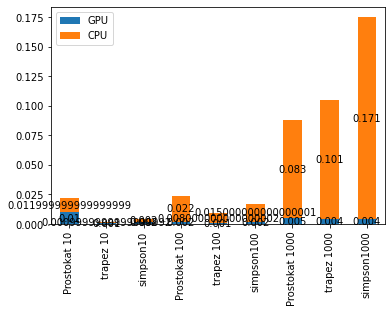

In [185]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({
  'GPU': [0.01, 0.001, 0.002,0.002, 0.001, 0.002,0.005, 0.004, 0.004],
  'CPU': [0.012, 0.001, 0.002,0.022, 0.008, 0.015,0.083, 0.101, 0.171]})

labels = ['Prostokat 10','trapez 10','simpson10','Prostokat 100','trapez 100','simpson100','Prostokat 1000','trapez 1000','simpson1000']

ax = df.plot(stacked=True, kind='bar')
for bar in ax.patches:
  height = bar.get_height()
  width = bar.get_width()
  x = bar.get_x()
  y = bar.get_y()
  label_text = height
  label_x = x + width / 2
  label_y = y + height / 2
  ax.text(label_x, label_y, label_text, ha='center', va='center')                                                

ax.set_xticklabels(labels,rotation='vertical')

plt.show()